In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import dill
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
import os
from pathlib import Path
import consts as C
import ipywidgets as widgets

from os import listdir
from os.path import isfile, join
import brian2 as b2
import datetime

In [2]:
results_dir = Path(os.getcwd()) / Path(C.Paths.RESULTS_DIR)
files = [f for f in listdir(results_dir) if isfile(join(results_dir, f))]
files.sort()
selected_files = []

file_selector = widgets.SelectMultiple(rows=10, options = files, description='Data files:', layout = widgets.Layout(width='fit-content'))
button = widgets.Button(description="Plot Selected")
show_lso_check = widgets.Checkbox(
    value=True,
    description='LSO',
    disabled=False,
    indent=False
)
show_mso_check = widgets.Checkbox(
    value=True,
    description='MSO',
    disabled=False,
    indent=False
)

ax = None

plt.rcParams['axes.grid'] = True
plt.rcParams["figure.figsize"] = (8,3)


In [3]:
def draw_rate_vs_angle(data, filename, show_lso = True, show_mso = True):
    angle_to_rate = data["angle_to_rate"]
    name = data["conf"]["model_desc"]["name"]
    sound_key = data["conf"]["sound_key"]
    # cochlea = data["conf"]["cochlea_type"]
    
    angles = list(angle_to_rate.keys())
    def average_firing_rate(x):
        active_neurons = set(x)
        return (len(x["times"])/len(active_neurons)) if len(active_neurons) >= 0 else 0

    arr_n_spikes_r_lso = [average_firing_rate(x["R"]["LSO"]["spikes"]) for angle, x in angle_to_rate.items()]
    arr_n_spikes_l_lso = [average_firing_rate(x["L"]["LSO"]["spikes"]) for angle, x in angle_to_rate.items()]
    arr_n_spikes_r_mso = [average_firing_rate(x["R"]["MSO"]["spikes"]) for angle, x in angle_to_rate.items()]
    arr_n_spikes_l_mso = [average_firing_rate(x["L"]["MSO"]["spikes"]) for angle, x in angle_to_rate.items()]

    lso = {
        "spikes": [arr_n_spikes_r_lso,arr_n_spikes_l_lso],
        "show": show_lso,
        "label": "lso"
    }
    mso = {
        "spikes": [arr_n_spikes_r_mso,arr_n_spikes_l_mso],
        "show": show_mso,
        "label": "mso"
    }
    data = []
    for i in [lso,mso]:
        if i["show"]:
            data.append(i)
    num_subplots = len(data)
    fig, ax = plt.subplots(num_subplots, figsize=(8, 2*num_subplots))
    if type(ax) is not np.ndarray:
        ax = [ax]
    for axis,d in zip(ax,data):
        axis.plot(angles, d["spikes"][0], ".-", label=f"right {d["label"]}")
        axis.plot(angles, d["spikes"][1], ".-", label=f"left {d["label"]}")
        axis.set_ylabel("avg spk/sec (Hz)")
        _ = axis.legend()
    # fig.suptitle(f"{name} with {sound_key}")
    plt.suptitle(filename)
    plt.setp([ax], xticks = angles)

    plt.tight_layout()
    plt.show()

In [12]:
from sorcery import dict_of


def show_stats(data, lso, mso):
    total_spikes_R_LSO = sum(
        [len(x["R"]["LSO"]["spikes"]["times"]) for angle, x in data["angle_to_rate"].items()]
    )
    total_spikes_L_LSO = sum(
        [len(x["L"]["LSO"]["spikes"]["times"]) for angle, x in data["angle_to_rate"].items()]
    )
    total_spikes_R_MSO = sum(
        [len(x["R"]["MSO"]["spikes"]["times"]) for angle, x in data["angle_to_rate"].items()]
    )
    total_spikes_L_MSO = sum(
        [len(x["L"]["MSO"]["spikes"]["times"]) for angle, x in data["angle_to_rate"].items()]
    )
    print(
        dict_of(
            total_spikes_R_LSO,
            total_spikes_L_LSO,
            total_spikes_R_MSO,
            total_spikes_L_MSO,
        )
    )

In [13]:
out = widgets.Output()

@out.capture(clear_output=True, wait=True)
def on_button_clicked(b):
    global file_selector, selected_files, ax, out, vbox, show_mso_check, show_lso_check,hbox
    selected_files = file_selector.value
    show_lso_v, show_mso_v = show_lso_check.value, show_mso_check.value
    # print("selected: ", selected_files)
    plt.close()
        
    for selected in selected_files:
        with open(join(results_dir, selected), "rb") as f:
            res = dill.load(f, ignore=True)
        with out:
            draw_rate_vs_angle(res, selected,show_lso_v, show_mso_v)
            show_stats(res,show_lso_v,show_mso_v)
    vbox.children = [file_selector, hbox, out]

hbox = widgets.HBox([button, show_lso_check,show_mso_check])

button.on_click(on_button_clicked)
vbox = widgets.VBox([file_selector, hbox])
display(vbox)

In [6]:
with open(join(results_dir,"tone_1.kHz&ppg&inh_model&default_params&2024-07-20T20:55:28.pic"), "rb") as f:
    res = dill.load(f, ignore=True)


In [7]:
current = res["angle_to_rate"][-90]["R"]["LSO"]["spikes"]
active_neurons = set(current["senders"])
# from generate_results import TIME_SIMULATION
average_firing_rate = (len(current["times"])/len(active_neurons))*b2.Hz if len(active_neurons) >= 0 else 0
average_firing_rate


0.472 * khertz

True

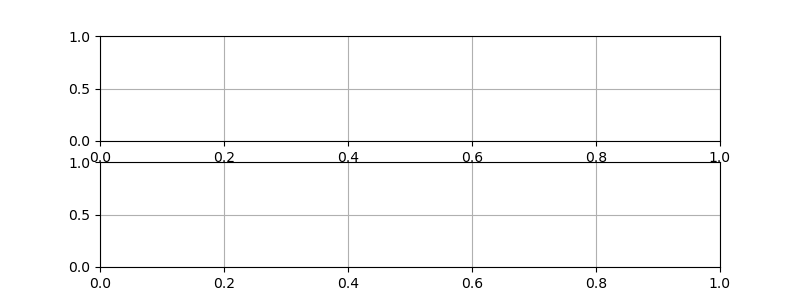

In [8]:
fix,ax = plt.subplots(2)
ax
type(ax) is np.ndarray

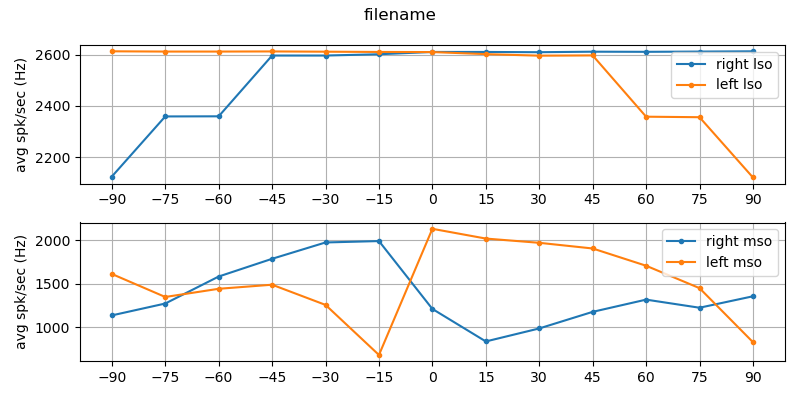

In [9]:
with open(join(results_dir,"tone_1.kHz&ppg&inh_model&default_params&2024-07-20T20:55:28.pic"), "rb") as f:
    res = dill.load(f, ignore=True)
draw_rate_vs_angle(res,"filename", True, True)